In [ ]:
pip install tensorflow==1.14.0

In [ ]:
pip install keras==2.0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Activation, BatchNormalization, Reshape, Lambda
from keras.objectives import binary_crossentropy
from keras.layers.advanced_activations import LeakyReLU
from keras.datasets import mnist

from keras import backend

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test  = x_test .astype('float32') / 255.

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test  = np.reshape(x_test,  (len(x_test),  28, 28, 1))

In [ ]:
latent_dim = 2
batch_size = 500
inputs = Input(batch_shape=(batch_size, 28, 28, 1))

## Sampling from Q

In [ ]:
def Q_sample(args):
  z_mean, z_log_var = args
  epsilon = backend.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
  return z_mean + backend.exp(z_log_var / 2) * epsilon

## Encoder and distribution parameters


In [ ]:
def encode(inputs):
  x = Flatten()(inputs)
  x = Dense(256, activation='relu')(x)
  x = Dropout(0.25)(BatchNormalization()(x))
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.25)(BatchNormalization()(x))

  z_mean = Dense(latent_dim)(x)
  z_log_var = Dense(latent_dim)(x)

  lam = Lambda(Q_sample, output_shape=(latent_dim,))([z_mean, z_log_var])
  encode_model =  Model(inputs, lam)
  
  return z_mean, z_log_var, encode_model

In [ ]:
z_mean, z_log_var, encode_model = encode(inputs)

## Decoder

In [ ]:
z = Input(shape=(latent_dim, ))

def decode(z):
  x = Dense(128)(z)
  x = LeakyReLU()(x)
  x = Dropout(0.25)(BatchNormalization()(x))
  x = Dense(256)(x)
  x = LeakyReLU()(x)
  x = Dropout(0.25)(BatchNormalization()(x))
  x = Dense(28*28, activation='sigmoid')(x)
  decoded = Reshape((28, 28, 1))(x)

  return Model(z, decoded)

In [ ]:
dencode_model = decode(z)

In [ ]:
vae_model = Model(inputs, dencode_model(encode_model(inputs)))

In [ ]:
def vae_loss(x, decoded):
  x = backend.reshape(x, shape=(batch_size, 28*28))
  decoded = backend.reshape(decoded, shape=(batch_size, 28*28))
  xent_loss = 28*28*binary_crossentropy(x, decoded)
  kl_loss = -0.5 * backend.sum(1 + z_log_var - backend.square(z_mean) - backend.exp(z_log_var), axis=-1)
  return (xent_loss + kl_loss)/2/28/28

In [ ]:
from keras.optimizers import Adam, RMSprop

vae_model.compile(optimizer=Adam(0.0001), loss=vae_loss)



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [ ]:
history = vae_model.fit(x_train, x_train, shuffle=True, epochs=50, batch_size=batch_size, verbose=1
                          )

Epoch 1/50
60000/60000 [==============================] - 11s - loss: 0.1072    
Epoch 2/50
60000/60000 [==============================] - 8s - loss: 0.1070     
Epoch 3/50
60000/60000 [==============================] - 8s - loss: 0.1070     
Epoch 4/50
60000/60000 [==============================] - 8s - loss: 0.1069     
Epoch 5/50
60000/60000 [==============================] - 8s - loss: 0.1068     
Epoch 6/50
60000/60000 [==============================] - 8s - loss: 0.1067     
Epoch 7/50
60000/60000 [==============================] - 8s - loss: 0.1067     
Epoch 8/50
60000/60000 [==============================] - 8s - loss: 0.1066     
Epoch 9/50
60000/60000 [==============================] - 8s - loss: 0.1065     
Epoch 10/50
60000/60000 [==============================] - 8s - loss: 0.1064     
Epoch 11/50
60000/60000 [==============================] - 8s - loss: 0.1063     
Epoch 12/50
60000/60000 [==============================] - 8s - loss: 0.1062     
Epoch 13/50
60000/60000 [

## Sampling from latent space


<function matplotlib.pyplot.show>

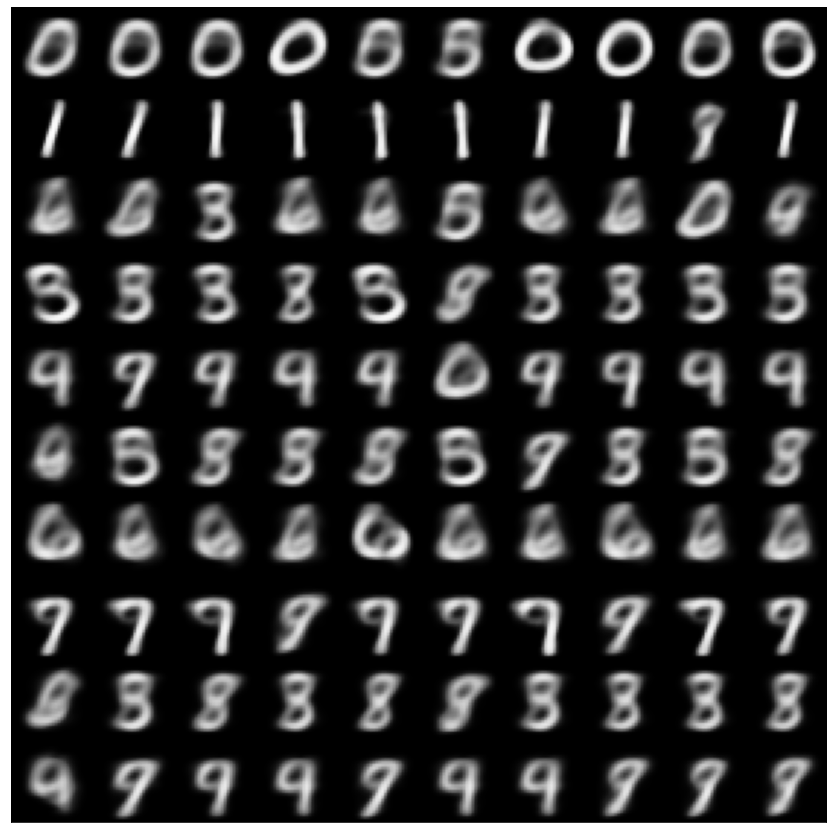

In [ ]:
digit_size = 28
n = 10
risunok = np.zeros((digit_size*n, digit_size*n))
for i in range(10):
  for j in range(10):
    digit = vae_model.predict(x_test[:batch_size],batch_size=batch_size)[y_test[:batch_size]==i][j].squeeze()
    risunok[i*digit_size: (i+1)*digit_size, j*digit_size: (j+1)*digit_size] = digit
plt.figure(figsize=(15,15))
plt.imshow(risunok,cmap = 'Greys_r')
plt.grid(None)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.show